<a href="https://colab.research.google.com/github/ottogin/digital_strawberry/blob/dev_egor/Agrohack_MaskRCNN_Big_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl

!pip install tensorflow==2.4.1
#!pip install keras==2.2.5

#import keras.backend as K
import tensorflow as tf
from copy import deepcopy
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/Agrohack/'

     |████████████████████████████████| 394.3 MB 15 kB/s 
     |████████████████████████████████| 2.9 MB 31.4 MB/s 
     |████████████████████████████████| 3.8 MB 37.7 MB/s 
     |████████████████████████████████| 462 kB 48.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=2c7f2bd226c8975d870f512543cb0bdb5a97e327f188abb41db2a04a4ee640cd
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

# Data

In [3]:
import cv2
mask=cv2.imread('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/StrawDI_Db1/train/label/2638.png')
img=cv2.imread('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/StrawDI_Db1/train/img/2638.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

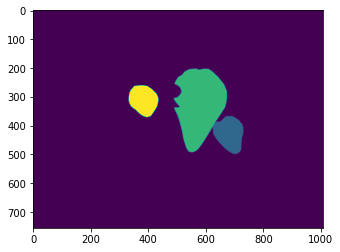

In [4]:
plt.imshow(mask[:,:,0])

# Train Mask RCNN beagle based

In [5]:
dataset_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/StrawDI_Db1/'
weights_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/MRCNN/mask_rcnn_coco.h5'
script_dir='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/fine-tune-MaskRcnn/beagle.py'

In [6]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

In [7]:
ROOT_DIR = os.path.abspath('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/')
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
COCO_WEIGHTS_PATH = weights_dir

sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import model as modellib,utils

# Code for training

In [8]:
from tqdm import tqdm

In [9]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "strawberry"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + beagle

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load the beagle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("strawberry", 1, "strawberry")

        # Train or validation dataset?
        assert subset in ["train", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        for index_file,filename in tqdm(enumerate(os.listdir(os.path.join(dataset_dir,'img')))):
            image_path = os.path.join(dataset_dir, 'img' ,filename)
            mask_path= os.path.join(dataset_dir, 'label' ,filename)
            image = skimage.io.imread(image_path)
            mask= skimage.io.imread(mask_path)
            height, width = image.shape[:2]
            self.add_image(
                "strawberry",  ## for a single class just add the name here
                image_id=filename,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=mask)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a beagle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "strawberry":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask_image = info["polygons"]
        detected_ids=np.unique(mask_image)[1:]

        mask = np.zeros([info["height"], info["width"], len(detected_ids)],
                        dtype=np.uint8)

        for i,id in enumerate(detected_ids):
            mask[:,:,i][mask_image==id]=1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "strawberry":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


from tensorflow.keras.callbacks import LambdaCallback
Checkpoints_Folder='drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Data/Checkpoints/'
def on_epoch_end(epoch=0, logs=''):
    Model_folder=Checkpoints_Folder+'/Model_epoch_{}.h5'.format(epoch)
    model.save_weights(Model_folder)

checkpoint_callback=LambdaCallback(on_epoch_end=on_epoch_end)

def train(model,config):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(dataset_dir, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(dataset_dir, "test")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=100,
                layers='heads')
    



def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)




In [10]:
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330/mask_rcnn_strawberry_0010.h5'

drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330/mask_rcnn_strawberry_0010.h5


In [ ]:
    command='train'

    if command == "train":
        config = CustomConfig()
    else:
        class InferenceConfig(CustomConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

    weights_path = COCO_WEIGHTS_PATH

    # Load weights
    print("Loading weights ", weights_path)
    
    # Exclude the last layers because they require a matching
    # number of classes

    '''
    model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    '''

    model.load_weights('drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330/mask_rcnn_strawberry_0010.h5', by_name=True)

    # Train or evaluate
    if command == "train":
        train(model,config)



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

2800it [51:06,  1.10s/it]
200it [03:45,  1.13s/it]


Training network heads

Starting at epoch 10. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330/mask_rcnn_strawberry_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

In [58]:
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330mask_rcnn_strawberry_0010.h5'

ls: cannot access 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330mask_rcnn_strawberry_0010.h5': No such file or directory


In [ ]:
from platform import python_version

print(python_version())

3.7.12


In [35]:
!ls 'drive/MyDrive/Argohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/strawberry20211120T2330'

ls: cannot access 'drive/MyDrive/Argohack': No such file or directory


In [ ]:
model.

In [ ]:
model.

In [51]:
cp -R 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330/' 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN/Mask-RCNN-leekunhee/logs/strawberry20211120T2330_backup'

In [50]:
!ls 'drive/MyDrive/Argohack/Dataset_Mask_RCNN'

ls: cannot access 'drive/MyDrive/Argohack/Dataset_Mask_RCNN': No such file or directory


In [49]:
!ls 'drive/MyDrive/Agrohack/Dataset_Mask_RCNN'

 Data		       Mask-RCNN-TF2	      StrawDI_Db1.zip
 fine-tune-MaskRcnn    MRCNN
 Mask-RCNN-leekunhee  'StrawDI_Db1 (1).zip'
